# Del 3 - Query Expansion

In [1]:
from helper_utils import load_chroma, word_wrap, project_embeddings
from chromadb.utils.embedding_functions import SentenceTransformerEmbeddingFunction

In [2]:
embedding_function = SentenceTransformerEmbeddingFunction()

chroma_collection = load_chroma(filename='microsoft_annual_report_2022.pdf', collection_name='microsoft_annual_report_2022', embedding_function=embedding_function)
chroma_collection.count()

/Users/kenanmahic/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Users/kenanmahic/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


349

In [3]:
import os
import openai
from openai import OpenAI

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
openai.api_key = os.environ['OPENAI_API_KEY']

openai_client = OpenAI()

In [4]:
import umap

embeddings = chroma_collection.get(include=['embeddings'])['embeddings']
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(embeddings)
projected_dataset_embeddings = project_embeddings(embeddings, umap_transform)

/Users/kenanmahic/Library/Python/3.9/lib/python/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
100%|██████████| 349/349 [01:46<00:00,  3.29it/s]


## Expansion with generated answers

https://arxiv.org/abs/2305.03653

![QueryExpansion](images/QueryExpansion.png)

En litt mer avansert måte å sette opp RAG-loopen vår er og først sende spørringen vår til en LLM uten å være innom en vektordatabase å be om et hypotetisk svar. Vi ber bokstavelig applikasjonen vår om hallusinere, men vi kommer til å bruke dette til noe nyttig!

La oss se på hvordan dette ser ut!

In [5]:
def augment_query_generated(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Provide an example answer to the given question, that might be found in a document like an annual report. "
        },
        {"role": "user", "content": query}
    ] 

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    return content

In [6]:
original_query = "Was there significant turnover in the executive team?"
hypothetical_answer = augment_query_generated(original_query)

joint_query = f"{original_query} {hypothetical_answer}"
print(word_wrap(joint_query))

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Was there significant turnover in the executive team? No, there was
minimal turnover in the executive team during the reporting period.
Only one executive departed due to retirement after a long and
successful tenure with the company. The remaining executives have
continued to lead the organization effectively and drive its strategic
initiatives forward.


I joint_query her var samlet den initielle spørringen vår og et hypotetisk svar. Spørsmålet dere kanskje stiller dere nå er om dette faktisk er nyttig. 

La oss ta en titt!

In [7]:
results = chroma_collection.query(query_texts=joint_query, n_results=5, include=['documents', 'embeddings'])
retrieved_documents = results['documents'][0]

for doc in retrieved_documents:
    print(word_wrap(doc))
    print('')

88 report of independent registered public accounting firm to the
stockholders and the board of directors of microsoft corporation
opinion on internal control over financial reporting we have audited
the internal control over financial reporting of microsoft corporation
and subsidiaries ( the “ company ” ) as of june 30, 2022, based on
criteria established in internal control — integrated framework ( 2013
) issued by the committee of sponsoring organizations of the treadway
commission ( coso ). in our opinion, the company maintained, in all
material respects, effective internal control over financial reporting
as of june 30, 2022, based on criteria establis hed in internal control
— integrated framework ( 2013 ) issued by coso. we have also audited,
in accordance with the standards of the public company accounting
oversight board ( united states ) ( pcaob ), the consolidated financial
statements as of and for the year ended june 30, 2022, of the company
and

51 stockholders ’ equity st

På samme måte som tidligere henter vi ut nærmeste resultater fra databasen og visualiserer

In [8]:
retrieved_embeddings = results['embeddings'][0]
original_query_embedding = embedding_function([original_query])
augmented_query_embedding = embedding_function([joint_query])

projected_original_query_embedding = project_embeddings(original_query_embedding, umap_transform)
projected_augmented_query_embedding = project_embeddings(augmented_query_embedding, umap_transform)
projected_retrieved_embeddings = project_embeddings(retrieved_embeddings, umap_transform)

100%|██████████| 5/5 [00:01<00:00,  3.34it/s]


(-4.870594072341919,
 3.1981850147247313,
 1.4880938410758973,
 11.311221373081207)

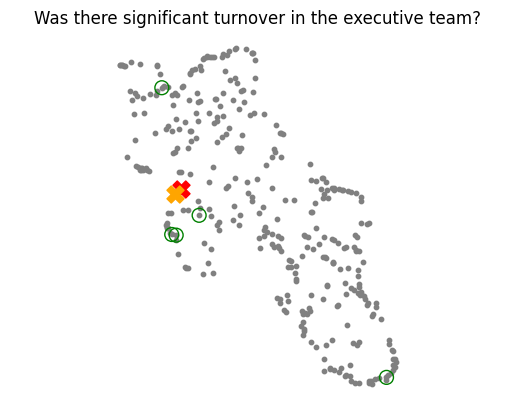

In [9]:
import matplotlib.pyplot as plt


plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(projected_retrieved_embeddings[:, 0], projected_retrieved_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(projected_original_query_embedding[:, 0], projected_original_query_embedding[:, 1], s=150, marker='X', color='r')
plt.scatter(projected_augmented_query_embedding[:, 0], projected_augmented_query_embedding[:, 1], s=150, marker='X', color='orange')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

Det røde krysset er den orginale spørringen og den oransje er spørringen kontatinert med det hypotetiske svaret. Som vi ser har det flyttet noe på seg og forhåpentligvis kommet noe nærmere det vi kan kalle et kluster av punkter. Potensielt en liten forbedring

## Expansion with multiple queries


![MultiQuery](images/Multiquery.png)

En kanskje hakket bedre metode som går i samme bane er å ta vår initielle spørring og be en LLM lage flere spørringer/spørsmål som muligens kan hjelpe å få riktig svar. Vi tar så og henter resultater for alle disse nye spørringene fra databasen som vi igjen syntetiserer sammen med den originale spørringen og sender til en LLM for svar på nytt

La se se på et eksempel

In [10]:
def augment_multiple_query(query, model="gpt-3.5-turbo"):
    messages = [
        {
            "role": "system",
            "content": "You are a helpful expert financial research assistant. Your users are asking questions about an annual report. "
            "Suggest up to five additional related questions to help them find the information they need, for the provided question. "
            "Suggest only short questions without compound sentences. Suggest a variety of questions that cover different aspects of the topic."
            "Make sure they are complete questions, and that they are related to the original question."
            "Output one question per line. Do not number the questions."
        },
        {"role": "user", "content": query}
    ]

    response = openai_client.chat.completions.create(
        model=model,
        messages=messages,
    )
    content = response.choices[0].message.content
    content = content.split("\n")
    return content

In [11]:
original_query = "What were the most important factors that contributed to increases in revenue?"
augmented_queries = augment_multiple_query(original_query)

for query in augmented_queries:
    print(query)

- How did the company's revenue compare to industry competitors?
- What were the key sales channels driving revenue growth?
- Were there any significant one-time events that impacted revenue?
- What impact did changes in pricing have on revenue?
- How did changes in customer demographics affect revenue growth?


Her har vi de 5 nye spørringene våre som vi bruker videre mot databasen

In [16]:
queries = [original_query] + augmented_queries
results = chroma_collection.query(query_texts=queries, n_results=5, include=['documents', 'embeddings'])

retrieved_documents = results['documents']

# Deduplicate the retrieved documents
unique_documents = set()
for documents in retrieved_documents:
    for document in documents:
        unique_documents.add(document)

for i, documents in enumerate(retrieved_documents):
    print(f"Query: {queries[i]}")
    print('')
    print("Results:")
    for doc in documents:
        print(word_wrap(doc))
        print('')
    print('-'*100)

Query: What were the most important factors that contributed to increases in revenue?

Results:
engineering, gaming, and linkedin. • sales and marketing expenses
increased $ 1. 7 billion or 8 % driven by investments in commercial
sales and linkedin. sales and marketing included a favorable foreign
currency impact of 2 %. • general and administrative expenses increased
$ 793 million or 16 % driven by investments in corporate functions.
operating income increased $ 13. 5 billion or 19 % driven by growth
across each of our segments. current year net income and diluted eps
were positively impacted by the net tax benefit related to the transfer
of intangible properties, which resulted in an increase to net income
and diluted eps of $ 3. 3 billion and $ 0. 44, respectively. prior year
net income and diluted eps were positively impacted by the net tax
benefit related to the india supreme court decision on withholding
taxes, which resulted in an increase to net income and diluted eps of $
620 

Alle disse nye spørringene gir oss forskjellige og relaterte chunks vi ikke hadde fått vanligvis. La oss visualisere.

In [17]:
original_query_embedding = embedding_function([original_query])
augmented_query_embeddings = embedding_function(augmented_queries)

project_original_query = project_embeddings(original_query_embedding, umap_transform)
project_augmented_queries = project_embeddings(augmented_query_embeddings, umap_transform)


100%|██████████| 5/5 [00:01<00:00,  3.26it/s]


In [18]:
result_embeddings = results['embeddings']
result_embeddings = [item for sublist in result_embeddings for item in sublist]
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)


100%|██████████| 30/30 [00:09<00:00,  3.26it/s]


(-4.870594072341919,
 3.1981850147247313,
 1.4880938410758973,
 11.311221373081207)

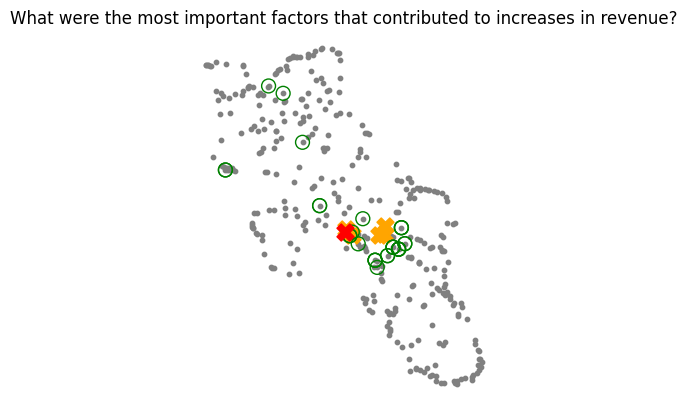

In [19]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1], s=10, color='gray')
plt.scatter(project_augmented_queries[:, 0], project_augmented_queries[:, 1], s=150, marker='X', color='orange')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1], s=100, facecolors='none', edgecolors='g')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1], s=150, marker='X', color='r')

plt.gca().set_aspect('equal', 'datalim')
plt.title(f'{original_query}')
plt.axis('off')

Som vi kan se av illustrasjonen gir disse nye spørringene oss en del mer grønne sirkler spredd utover hele datasettet som kan være relatert til den orginale spørringen. Vi kunne så klart bare økt antallet resulter vi henter for en spørring, men n måte å tenke på dette er at en enkel spørring projiseres til et enkelt punkt i vektorrommet. Og at de nærmeste naboene til dette ene punktet mest sannsynlig ikke har all den relevante informasjonen som du trenger for å svare ut mer komplekse spørringer. Så å bruke denne metoden gir oss en bedre sjanse å fange opp all den relevante informasjonen. Nedsiden er selvfølgelig at vi har et mye større resultatsett og vi er ikke sikre på hvilke om noen av alle disse svarene faktisk er relevante for den originale spørringen vår. I neste del ser vi på en metode for å ranke disse resultatene slik at vi bare henter ut det vi føler er nyttig for den originale spørringen vår-